The main example is from [SHAP Documentation](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/tree_explainer/Scatter%20Density%20vs.%20Violin%20Plot%20Comparison.html) - I added so extra explanations

In [1]:
import xgboost
import shap

In [2]:
# train xgboost model on diabetes data:
X, y = shap.datasets.diabetes()
bst = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's prediction using SHAP values on the first 1000 training data samples
shap_values = shap.TreeExplainer(bst).shap_values(X)

[10:10:32] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [3]:
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


## Layered violin plot

Without color, this plot can simply display the distribution of importance for each variable as a standard violin plot.

In [8]:
shap_values.shape

(442, 10)

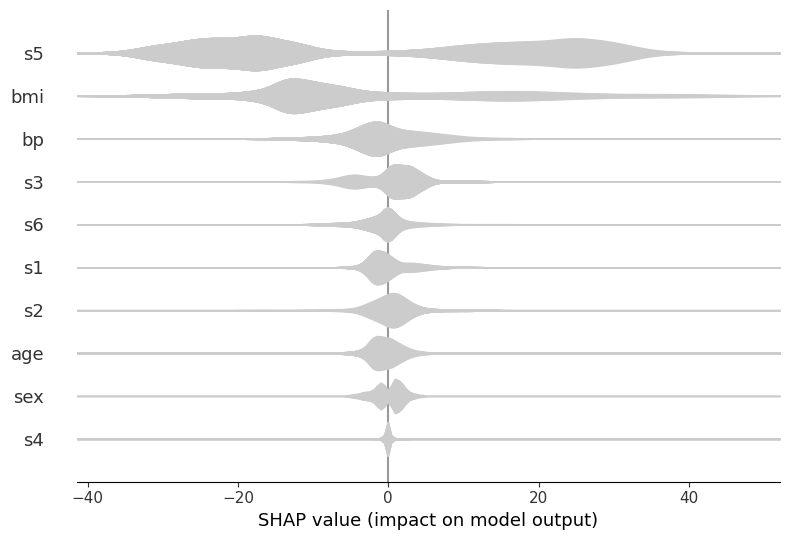

In [9]:
shap.summary_plot(shap_values,
                  X,
                  plot_type="layered_violin",
                  color='#cccccc')

For example, in the above, we can see that `s5` is the most important variable, and generally it causes either a large positive or negative change in the prediction. However, is it large values of `s5` that cause a positive change and small ones that cause a negative change - or vice versa, or something more complicated? If we use color to represent the largeness/smallness of the feature, then this becomes apparent:

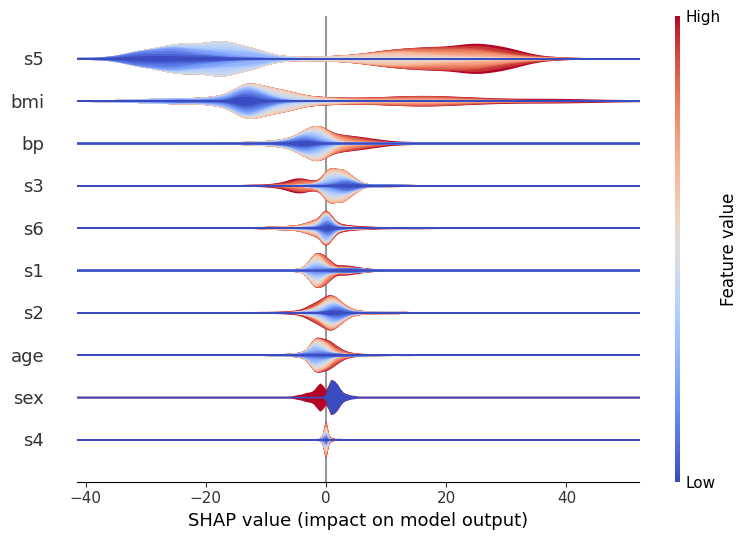

In [7]:
shap.summary_plot(shap_values[:1000, :],
                  X.iloc[:1000, :],
                  plot_type="layered_violin",
                  color='coolwarm')

Here, red represents large values of a variable, and blue represents small ones. So, it becomes clear that large values of `s5` do indeed increase the prediction, and vice versa. You can also see that others (like `s6`) are pretty evenly split, which indicates that while overall they’re still important, their interaction is dependent on other variables. (After all, the whole point of a tree model like xgboost is to capture these interactions, so we can’t expect to see everything in a single dimension!)

Note that the order of the color isn’t important: each violin is actually a number (`layered_violin_max_num_bins`) of individual smoothed shapes stacked on top of each other, where each shape corresponds to a certain percentile of the feature (e.g., the 5-10% percentile of `s5` values). These are always drawn with small values first (and hence closest to the x-axis) and large values last (hence on the ‘edge’), and that’s why in this case you always see the red on the edge and the blue in the middle. (You could, of course, switch this round by using a different color map, but the point is that the order of red inside/outside blue has no inherent meaning.)

There are other options you can play with, if you wish. Most notable is the `layered_violin_max_num_bins` mentioned above. This has an additional effect that if the feature has less that `layered_violin_max_num_bins` unique values, then instead of partitioning each section as a percentile (the 5-10% above), we make each section represent a specific value. For example, since `sex` has only two values, here blue will mean male (or female?) and red means female (or male?). Not sure with the diabetes data if a higher value of `sex` means male or female.


## Dot plot

This combines a scatter plot with density estimation by letting dots pile up when they don’t fit. The advatange of this approach is that it does not hide anything behind kernel smoothing, so what-you-see-is-what-is-there.

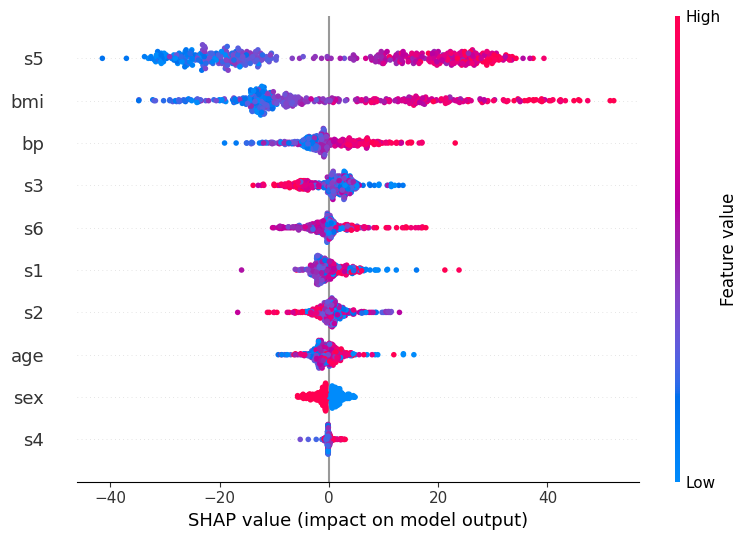

In [8]:
shap.summary_plot(shap_values[:1000,:], X.iloc[:1000,:])


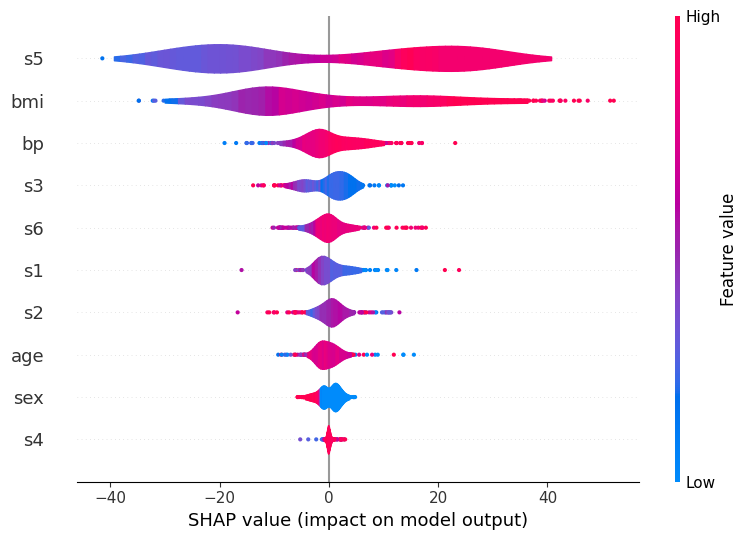

In [9]:
shap.summary_plot(shap_values[:1000, :], X.iloc[:1000, :], plot_type="violin")

Each point on the plot represents a Shapley value for a feature and an instance. The position on the x-axis indicates the SHAP value, which shows the impact on the model output. A point's color represents the feature value (high or low).

- `s5` has a high positive impact on the model's prediction; higher values of `s5` increase the prediction.
- `bmi` has both positive and negative impacts, suggesting a complex relationship with the outcome.
- Features like `s6`, `s1`, `s2`, and `s4` have varied impacts, with clusters of points on both sides of the zero line, indicating their effects depend on their interaction with other features.
- `age` and `sex` appear to have a smaller but still notable impact, with `sex` showing a clear distinction in impact based on its binary values.
